In [1]:
import pandas as pd
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler,MaxAbsScaler
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import classification_report, f1_score
from sklearn.pipeline import Pipeline

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem.snowball import SnowballStemmer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Wadu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Wadu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Wadu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Load the data

In [3]:
dataset = pd.read_csv(r'D:\Radu\fac\master\PML\Restanta\tweet_emotions.csv')
lista_sentimente_sterse = ['anger', 'boredom', 'enthusiasm', 'hate','empty','relief','fun','surprise']

df = dataset[~dataset['sentiment'].isin(lista_sentimente_sterse)]

In [5]:
distributie_clase_sentimente = df['sentiment'].value_counts()
print(distributie_clase_sentimente)

sentiment
neutral      8638
worry        8459
happiness    5209
sadness      5165
love         3842
Name: count, dtype: int64


### Normalizing

In [6]:

from nltk.stem import WordNetLemmatizer

stemmer = SnowballStemmer('english')

def normalizare(text):
    # eliminare URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # eliminare user @ references and '#' 
    text = re.sub(r'\@\w+|\#','', text)

    # eliminare semne du punctuatie
    text = re.sub(r'[^\w\s]', '', text)

    # text mic
    text = text.lower()

    word_tokens = word_tokenize(text)
    
    # Stemming
    stemmed_tokens = [stemmer.stem(token) for token in word_tokens]
    
    filtered_text = [word for word in stemmed_tokens]
    
    return " ".join(filtered_text)

amaz i manag to get work done visit for more info product
['@', 'user', 'Amazingly', ',', 'I', 'managed', 'to', 'get', 'work', 'done', '!', 'Visit', 'http', ':', '//example.com', 'for', 'more', 'info', '.', '#', 'productivity']


### Train test split

In [7]:

X = df['content'].apply(normalizare)
Y = df['sentiment']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [20]:

tf_idf = TfidfVectorizer(ngram_range=(1,1))

# Fit transform datele din antrenare si transform setul de test
X_train_tfidf = tf_idf.fit_transform(X_train)
X_test_tfidf = tf_idf.transform(X_test)

In [14]:
count_vect = CountVectorizer(ngram_range=(1,1))

# Fit transform datele din antrenare si transform setul de test
X_train_counts = count_vect.fit_transform(X_train)
X_test_counts = count_vect.transform(X_test)


In [50]:
# antrenarea modelului
logistic_model = LogisticRegression(class_weight='balanced',verbose=2,max_iter=3500,C=0.1,solver='saga')
logistic_model.fit(X_train_counts, y_train)

convergence after 36 epochs took 0 seconds


LogisticRegression(C=0.1, class_weight='balanced', max_iter=3500, solver='saga',
                   verbose=2)

In [51]:
# predict pe datele de test
y_pred = logistic_model.predict(X_test_counts)

# evaluarea modelului
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   happiness       0.41      0.43      0.42      1034
        love       0.48      0.49      0.49       809
     neutral       0.49      0.55      0.52      1683
     sadness       0.41      0.46      0.43      1107
       worry       0.45      0.34      0.39      1630

    accuracy                           0.45      6263
   macro avg       0.45      0.45      0.45      6263
weighted avg       0.45      0.45      0.45      6263



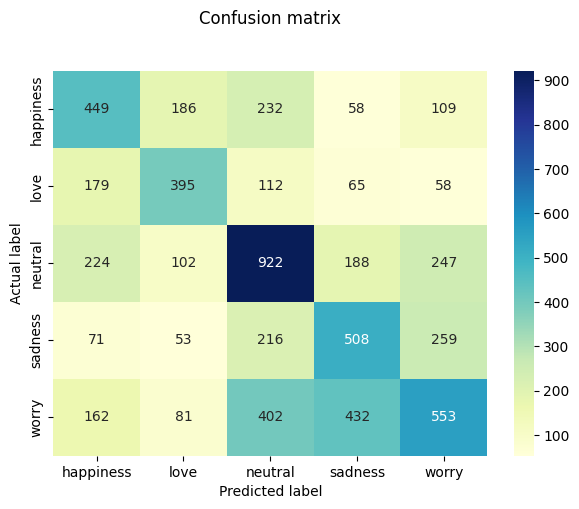

In [37]:

# calcularea matricei de confuzie
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

nume_clase = ['happiness', 'love', 'neutral', 'sadness', 'worry']

# creare heatmap
plt.figure(figsize=(7, 5)) 
sns.heatmap(cnf_matrix, annot=True, cmap="YlGnBu", fmt='g', 
            xticklabels=nume_clase, yticklabels=nume_clase)
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()


In [54]:

# definire pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('logreg', LogisticRegression())
])

parametrii_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'logreg__C': [0.1,0.15,0.08,0.17,0.2],
    'logreg__solver': ['lbfgs', 'saga'],
    'logreg__class_weight': ['balanced'],
    'logreg__max_iter': [3500]
}
rezultate = []

grid = ParameterGrid(parametrii_grid)


for params in grid:
    # setarea parametrilor pentru configuratia actuala
    pipeline.set_params(**params)
    
    # Fit pe train
    pipeline.fit(X_train, y_train)
    
    # predict pe validare
    y_pred = pipeline.predict(X_test)
    
    #calculare macro f1
    current_f1_score = f1_score(y_test, y_pred, average = 'macro')

    #stocam datele 
    rezultate.append({'score': current_f1_score, 'params': params})

    print("Current Parameters:", params)
    print(classification_report(y_test, y_pred))
    print(f"Macro F1 Score: {f1_score(y_test, y_pred, average='macro')}\n")

#calculam cel mai bun rezultat
cel_mai_bun_rezultat = max(rezultate, key = lambda x: x['score'])

max_scor = cel_mai_bun_rezultat['score']
parametrii = cel_mai_bun_rezultat['params']

print("Cel mai bun macro f1: ",max_scor)
print("Parametrii: ", parametrii)

Current Parameters: {'logreg__C': 0.1, 'logreg__class_weight': 'balanced', 'logreg__max_iter': 3500, 'logreg__solver': 'lbfgs', 'tfidf__ngram_range': (1, 1)}
              precision    recall  f1-score   support

   happiness       0.39      0.44      0.42      1034
        love       0.49      0.48      0.49       809
     neutral       0.48      0.47      0.47      1683
     sadness       0.39      0.46      0.42      1107
       worry       0.43      0.36      0.39      1630

    accuracy                           0.44      6263
   macro avg       0.44      0.44      0.44      6263
weighted avg       0.44      0.44      0.44      6263

Macro F1 Score: 0.4380162251408149

Current Parameters: {'logreg__C': 0.1, 'logreg__class_weight': 'balanced', 'logreg__max_iter': 3500, 'logreg__solver': 'lbfgs', 'tfidf__ngram_range': (1, 2)}
              precision    recall  f1-score   support

   happiness       0.39      0.45      0.42      1034
        love       0.49      0.49      0.49       